This analysis method is intended to convert flow cytometry data to MEFL using calibration beads. Make a folder for a single flow cytometery run that contains this file as well as folders named "samples" and "beads." Place the .fcs files for your samples in the samples folder and the beads in the beads folder.

This analysis method was written to account for blank, non-fluorescent beads mixed with the fluorescent calibration beads, as recommended by Spherotec. These blank beads are the same size as the calibration beads and are not gated out with the default 2D density gating used by the FlowCal Excel analysis template. The inclusion of the blank beads throws off the calibration curve.

This script will function for bead populations that contain only calibration beads and no blanks, but it is probably easier to simply use the standard FlowCal Excel template for those experiments.

To use this script, either step through the instructions and run each code cell as you go, or fill in all the required information and then run all cells together. Do not skip to the middle of the protocol and attempt to run segments of code, as it will not work.

This script was written by Kevin Keating on 5/25/2022 and run on Python 3.9.13.

In [1]:
# Import all packages required for this script
import FlowCal
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from pathlib import Path
import pandas as pd
from collections import OrderedDict
from natsort import os_sorted

If any of the above packages are not installed on your computer, you may get an error like "package x not found." This will probably happen for FlowCal and natsort since they are not common or default packages. To install these packages, open up a terminal shell and write the following commands:

pip install FlowCal
pip install natsort

etc.

Write the file name for the flow cytometery data for your calibration beads in single quotes below, then run the section of code by pressing the "play" button to the left of the cell.

In [2]:
# Change the below values as needed
bead_file_name = 'beads-1.fcs'

The code below will read in the data from the bead file and make a scatter plot based on the FSC and SSC channels (size and complexity, roughly). You should see a population of events concentrated in a high density region (red/orange/yellow/green), as well as some lower density noise and saturation events (blue/indigo/violet).

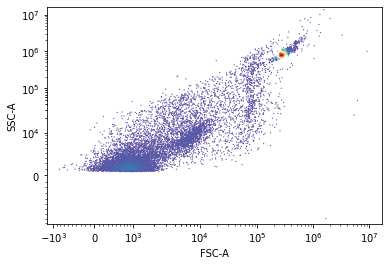

In [3]:
# Changing the below code should not be necessary
bead_path = './beads/'+bead_file_name
b = FlowCal.io.FCSData(bead_path)
b = FlowCal.gate.start_end(b, num_start=250, num_end=100) # Removes first 250 and last 100 events, used in FlowCal excel_ui script
b_transformed = FlowCal.transform.to_rfi(b, channels='FL1-A') # this converts the raw voltage values for FL1-A (GFP-A) to Relative Fluorescent Intensity (AU)
FlowCal.plot.density2d(b_transformed, channels=['FSC-A', 'SSC-A'], mode='scatter')
plt.show()

For the set of data I used to write this code, it was pretty clear that all of my beads had FSC and SSC values above 10^5. Deleting all noise events below this value is called gating. Look at your data and determine whether these gates are appropriate or change them as needed. 

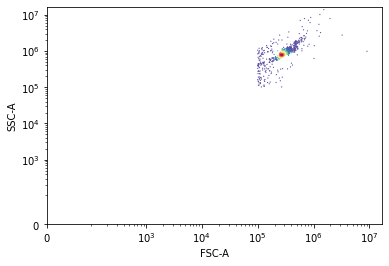

In [4]:
# Change the below values as needed
FSC_low_gate = 10**5    # This notation is "python" for 10^5
SSC_low_gate = 10**5


# Changing the below code should not be necessary
b_gated1 = FlowCal.gate.high_low(b_transformed, channels=['FSC-A'], low = FSC_low_gate)
b_gated2 = FlowCal.gate.high_low(b_gated1, channels=['SSC-A'], low = SSC_low_gate)
FlowCal.plot.density2d(b_gated2, channels=['FSC-A', 'SSC-A'], mode='scatter')
plt.show()

If the gated population looks reasonable, continue. Otherwise adjust the gate values as needed.

The histograms below are fluorescent intensities of the beads. There should be a sharp peak for each sub-population of beads at a specific intensity, which we will later correlate to known MEF values. For Spherotec URCP-38-2K beads, there will be 5 sharp peaks. If the blanks are mixed in, there will also be a lower, broader peak close to zero (but nonzero due to autofluorescence). We want to gate out that blank bead peak (if it exists), so we will pick a gate value between the blank bead peak and the lowest sharp bead peak. For this analysis set, 10^3.5 AU was a good value.

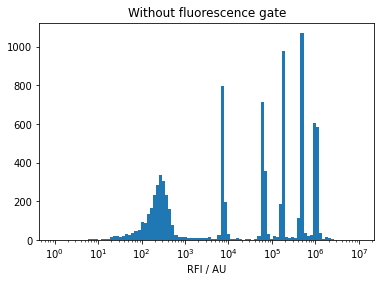

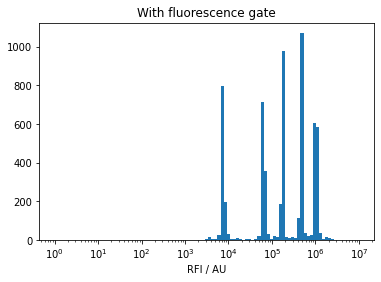

In [5]:
# Change the below value as needed
fluorescence_gate = 10**3.5 


# Changing the below code should not be necessary
bins = np.logspace(0, 7, 100)
plt.hist(b_gated2[:, 'FL1-A'], bins=bins)
plt.xscale('log')
plt.title('Without fluorescence gate')
plt.xlabel('RFI / AU')
plt.show()

b_gated3 = FlowCal.gate.high_low(b_gated2, channels=['FL1-A'], low = fluorescence_gate)
plt.hist(b_gated3[:, 'FL1-A'], bins=bins)
plt.xscale('log')
plt.title('With fluorescence gate')
plt.xlabel('RFI / AU')
plt.show()

If the blank bead peak has been removed without removing any of the fluorescent bead peaks, proceed. Otherwise, change the value for "fluorescence gate" in the above cell and rerun.

The plot below shows the remaining bead population before an after applying a light density gate to tighten up data. Adjust the percent of cells to keep as needed.

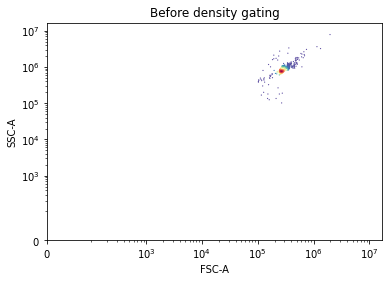

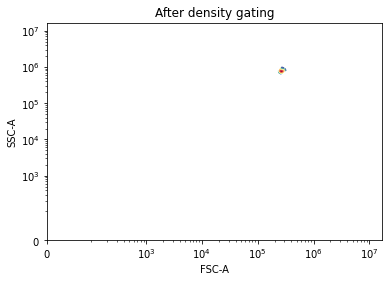

Final number of events kept is 5744


In [6]:
# Change the below value as needed
percent_events_to_keep = 95

# Changing the below code should not be necessary
FlowCal.plot.density2d(b_gated3, channels=['FSC-A', 'SSC-A'], mode='scatter', title='Before density gating')
plt.show()

b_gated4 = FlowCal.gate.density2d(b_gated3, channels=['FSC-A','SSC-A'], gate_fraction=percent_events_to_keep/100)
FlowCal.plot.density2d(b_gated4, channels=['FSC-A', 'SSC-A'], mode='scatter', title='After density gating')
plt.show()
print('Final number of events kept is %d' % (b_gated4.shape[0]))

The final population of cells should be ready to use to construct a calibration curve. Each lot of beads has its of target values for each channel, you need to get these from the manufacturer. The MEFL values for Spherotec URCP-38-2K beads lot AN02 are used below as default values.

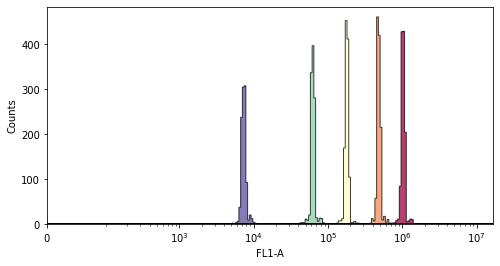

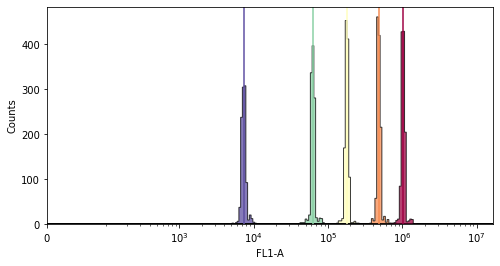

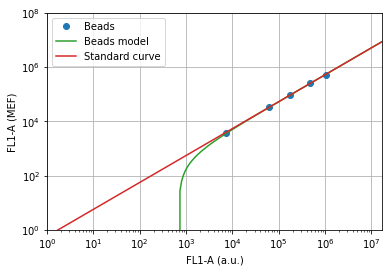

In [7]:
# Change the below value as needed
mefl_values = np.array([3604, 32375, 93912, 251415, 521377])

# Changing the below code should not be necessary
to_mef = FlowCal.mef.get_transform_fxn(b_gated4, mef_values=mefl_values, mef_channels='FL1-A', plot=True)
plt.show()

Each sharp peak should be a different color, the vertical line for each color should be at the median of the appropriate peak, and all of the bead values should line up well on the linear standard curve. If all of these things are true, the calibration curve is ready to be applied to the samples.

For reference, this is (roughly) what the calibration curve would have looked like with the default gating parameters. The default script was not replicated exactly. Uncomment the code section to view, the script fails with some bead populations (the reason why the above method was developed).

In [8]:
# Changing the below code should not be necessary
# b_gated_default = FlowCal.gate.start_end(b_transformed, num_start=250, num_end=100)
# b_gated_default = FlowCal.gate.high_low(b_gated_default, channels=['FSC-A', 'SSC-A'])
# b_gated_default = FlowCal.gate.density2d(b_gated_default, channels=['FSC-A','SSC-A'], gate_fraction=0.45)
# to_mef_default = FlowCal.mef.get_transform_fxn(b_gated_default, mef_values=mefl_values, mef_channels='FL1-A', plot=True)
# plt.show()

The "to_mef" object contains the calibration curve which we will apply to each sample. We will now test the calibration curve and the gating procedure on the first file in the samples folder. Note that a higher gating fraction may be appropriate for the samples than the beads (the cells are at a higher concentration in the sample so the signal to noise ratio is higher). Adjust as necessary.

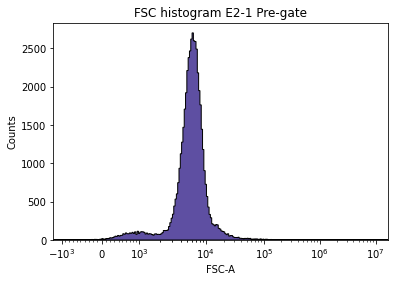

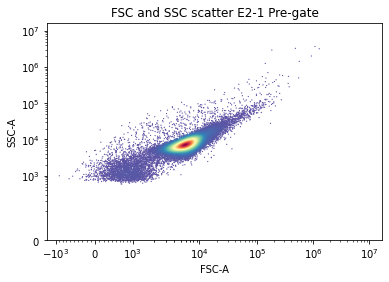

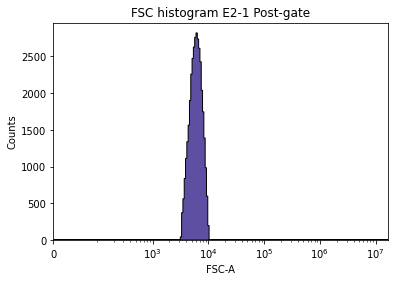

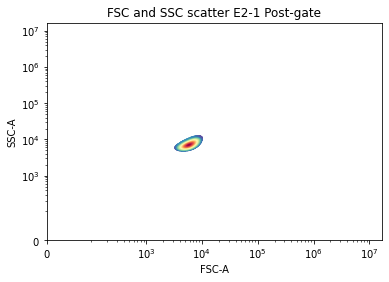

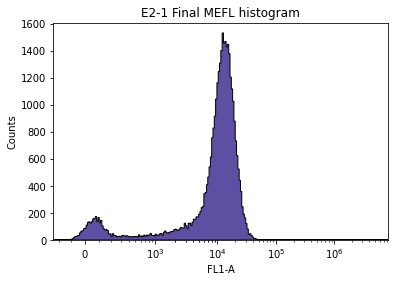

Final number of events kept is 35409
Arithmetic mean MEFL = 11553
Geometric mean of positive events = 7266


In [9]:
# Change the below value as needed
gate_fraction = 0.75
cell_FSC_low_gate = 10**3.1    # Different species will have different FSC and SSC values as well as different amounts of debris (slower growing cells tend to accumulate more debris) so these numbers should be adjusted as needed
cell_SSC_low_gate = 10**3.1

# Changing the below code should not be necessary
test_sample = os.listdir('./samples')[0]

# Read in and plot raw data
s = FlowCal.io.FCSData('./samples/'+test_sample)
FlowCal.plot.hist1d(s, channel='FSC-A', title='FSC histogram %s Pre-gate' %test_sample.split('.')[0])
plt.show()
FlowCal.plot.density2d(s, channels=['FSC-A', 'SSC-A'], mode='scatter', title='FSC and SSC scatter %s Pre-gate' %test_sample.split('.')[0])
plt.show()

# Transform RFI to AU, AU to MEF, and apply gates
s_transformed = FlowCal.transform.to_rfi(s)
s_truncated = FlowCal.gate.start_end(s_transformed, num_start=250, num_end=100) # Removes first 250 and last 100 events, used in FlowCal excel_ui script
s_mef = to_mef(s_truncated, channels='FL1-A')
s_gated1 = FlowCal.gate.high_low(s_mef, channels=['FSC-A', 'SSC-A'], low = cell_FSC_low_gate) # Gates out low debris
s_gated2 = FlowCal.gate.high_low(s_gated1, channels=['FSC-A', 'SSC-A'], low = cell_FSC_low_gate) # Gates out low debris
s_gated3 = FlowCal.gate.density2d(s_gated2, channels=['FSC-A', 'SSC-A'], gate_fraction=gate_fraction) # Density gate based on user-defined percent cells to keep

# Show plots of gated data
FlowCal.plot.hist1d(s_gated3, channel='FSC-A', title='FSC histogram %s Post-gate' %test_sample.split('.')[0])
plt.show()
FlowCal.plot.density2d(s_gated3, channels=['FSC-A', 'SSC-A'], mode='scatter', title='FSC and SSC scatter %s Post-gate' %test_sample.split('.')[0])
plt.show()
FlowCal.plot.hist1d(s_gated3, channel='FL1-A', title='%s Final MEFL histogram' %test_sample.split('.')[0])
plt.show()

# Slice out positive numbers for geometric mean calculation
MEFL_vals = np.array(s_gated3[:, ['FL1-A']])
MEFL_positives = MEFL_vals[MEFL_vals>0]

# Display summary statistics
print('Final number of events kept is %d' % (s_gated3.shape[0]))
print('Arithmetic mean MEFL = %d' %FlowCal.stats.mean(s_gated3, channels='FL1-A'))
print('Geometric mean of positive events = %d' %scipy.stats.gmean(MEFL_positives))

If everything looks right, run the final settings on all the .fcs samples.

The script below will read each .fcs file in the samples folder, apply a gating procedure, convert the fluorescence values to MEFL, generate plots of the process, and tabulate stats in a spreadsheet.

In [10]:
# Changing the below code should not be necessary
# Create a list of files in the samples folder
sample_directory = './samples/'
files = os_sorted(Path(sample_directory).glob('*.fcs'))

# Initialized the dictionary to hold the statistics info
stats = OrderedDict([('sample' , []),
          ('GFP_geom_mean' , []),
          ('GFP_geom_stdev' , []),
          ('GFP_median' , []),
          ('FSC_mean' , []),
          ('count' , [])])

long_data_dict = OrderedDict([('sample' , []),
          ('MEFL_value' , [])])

sample_long_array = np.empty((0,1),dtype=np.str_)
run_long_array = np.empty((0,1),dtype=np.str_)
MEFL_long_array = np.empty((0,1),dtype=np.float64)
FSC_long_array = np.empty((0,1),dtype=np.float64)
SSC_long_array = np.empty((0,1),dtype=np.float64)

# Make folders to hold output files
if not os.path.exists('FlowCal_plots'):
    os.mkdir('FlowCal_plots')
if not os.path.exists('FlowCal_stats'):
    os.mkdir('FlowCal_stats')
if not os.path.exists('FlowCal_MEFL_CSVs'):
    os.mkdir('FlowCal_MEFL_CSVs')

for file in files:
    # Record the name of the sample file as the sample name
    file_short = os.path.split(file)[1]
    stats['sample'].append(file_short.replace('.fcs',''))
    
    # Read in and plot raw data
    s = FlowCal.io.FCSData(sample_directory+file_short)
    FlowCal.plot.hist1d(s, channel='FSC-A', title='%s FSC histogram Pre-gate' %file_short.replace('.fcs',''))
    plt.savefig(fname='./FlowCal_plots/'+file_short.split('.')[0]+ ' 01 FSC histogram Pre-gate.png'); plt.close()
    FlowCal.plot.density2d(s, channels=['FSC-A', 'SSC-A'], mode='scatter', title='%s FSC and SSC scatter Pre-gate' %file_short.replace('.fcs',''))
    plt.savefig(fname='./FlowCal_plots/'+file_short.split('.')[0]+' 03 FSC and SSC scatter Pre-gate.png'); plt.close()
    
    # Transform RFI to AU, AU to MEF, and apply gates
    s = FlowCal.transform.to_rfi(s)
    s = FlowCal.gate.start_end(s, num_start=250, num_end=100) # Removes first 250 and last 100 events, used in FlowCal excel_ui script
    s_mef = to_mef(s, channels='FL1-A')
    s_g = FlowCal.gate.high_low(s_mef, channels=['FSC-A', 'SSC-A'], low = cell_FSC_low_gate) # Gates out low debris
    s_g = FlowCal.gate.high_low(s_g, channels=['FSC-A', 'SSC-A'], low = cell_FSC_low_gate) # Gates out low debris
    s_g = FlowCal.gate.density2d(s_g, channels=['FSC-A', 'SSC-A'], gate_fraction=gate_fraction) # Density gate based on user-defined percent cells to keep
    FlowCal.plot.hist1d(s_g, channel='FSC-A', title='%s FSC histogram Post-gate' %file_short.replace('.fcs',''))
    plt.savefig(fname='./FlowCal_plots/'+file_short.split('.')[0]+' 02 FSC histogram Post-gate.png'); plt.close()
    FlowCal.plot.density2d(s_g, channels=['FSC-A', 'SSC-A'], mode='scatter', title=' %s FSC and SSC scatter Post-gate' %file_short.replace('.fcs',''))
    plt.savefig(fname='./FlowCal_plots/'+file_short.split('.')[0]+' 04 FSC and SSC scatter Post-gate.png'); plt.close()
    FlowCal.plot.hist1d(s_g, channel='FL1-A', title='%s Final MEFL histogram' %file_short.replace('.fcs',''))
    plt.savefig(fname='./FlowCal_plots/'+file_short.split('.')[0]+' 05 MEFL histogram Post-gate.png'); plt.close()
    
    # Write out MEFL values to a separate .csv file for each sample for future analysis
    #np.savetxt("./FlowCal_MEFL_CSVs/%s.csv" %file_short, s_g[:, ['FL1-A']], delimiter=",")

    # Slice out positive numbers for geometric mean calculation
    MEFL_vals = np.array(s_g[:, ['FL1-A']])
    MEFL_positives = MEFL_vals[MEFL_vals>0]

    # Append values to be ouput to a csv to a dictionary in long format
    MEFL_long_array = np.append(MEFL_long_array,MEFL_vals)
    FSC_long_array = np.append(FSC_long_array,np.array(s_g[:, ['FSC-A']]))
    SSC_long_array = np.append(SSC_long_array,np.array(s_g[:, ['SSC-A']]))
    sample_long_array = np.append(sample_long_array,np.tile(np.array(file_short.replace('.fcs','')),np.shape(MEFL_vals)))
    run_long_array =  np.append(run_long_array,np.tile(np.array(os.path.basename(os.getcwd())),np.shape(MEFL_vals)))
    
    # Calculate statistics for MEFL-converted flow data
    stats['GFP_geom_mean'].append(scipy.stats.gmean(MEFL_positives)) #calculated for positive numbers only
    stats['GFP_median'].append(FlowCal.stats.median(s_g, channels='FL1-A'))
    stats['GFP_geom_stdev'].append(scipy.stats.gstd(MEFL_positives)) #calculated for positive numbers only                                  
    stats['FSC_mean'].append(FlowCal.stats.mean(s_g, channels='FSC-A'))
    stats['count'].append(s_g.shape[0])

# Write stats out to Excel file
stats_df = pd.DataFrame(stats)
cwd = os.getcwd()
stats_df.to_excel(excel_writer='./FlowCal_stats/'+cwd.split("/")[-1]+'_stats.xlsx', index=False)

# Write long_data_dict out to CSV for downstream analysis / plotting of MEFL values for each event (one .CSV for all samples together, in long format)
long_record = np.rec.fromarrays((sample_long_array, run_long_array, MEFL_long_array, FSC_long_array, SSC_long_array), names=('sample', 'run_id', 'MEFL', 'FSC', 'SSC'))
np.savetxt(fname='./FlowCal_MEFL_CSVs/'+cwd.split("/")[-1]+'_all_events.csv',X=long_record, delimiter = ",",fmt='%0s',header='sample,run_id,MEFL,FSC,SSC',comments='')

Take a look through the histograms and make sure everything makes sense. If the gating looks off, tweak paramaters as needed, delete the ouput folders and rerun the entire script.